Importing the needed packages

In [1]:
from os import sep
import numpy as np
import matplotlib.pyplot as plt
# import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord

Writing the funtions needed

generate_RA_DEC_mesh generates RA and DEC mesh for the DATA which will be used for calculating the distances between different points.

Calc_l find the distance between two points on the space returns the value in arcsecond


In [2]:

def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = int(hdr.header['CRPIX1'])
    DEC_ref = int(hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute



Importing the FITs file and some testing the data

In [3]:

FITS1 = 'FITS_file/OMC_BandE.fits'
hdul = fits.open(FITS1)
# print(hdul.info())
Pol_angle = hdul[11].data

# # evt_data = Table(hdul[18].data)
# # print(evt_data.colnames)
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
# # print(1.5*0.5*(DEC_grid[1,0] - DEC_grid[0,0])*60)

# # plt.figure()
# # ax1 = plt.subplot(121)
# # ax1.imshow(DEC_grid)
# # ax2 = plt.subplot(122)
# # ax2.imshow(RA_grid)
# # plt.show()


Finding the value of angle dispersion function at the value 50,50 (pixel value)

1st step: selecting points that lie in the annular ring

2nd step: use this grid to select the polarization angles that lie in the annular ring

3rd step: find the difference between the polarization angle at (50,50) and the annular ring

4th step: square the difference and find rms value which will be the angle dispersion value

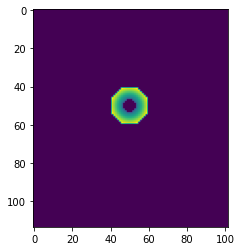

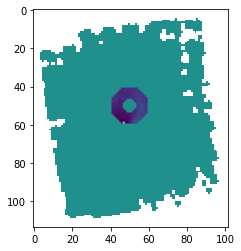

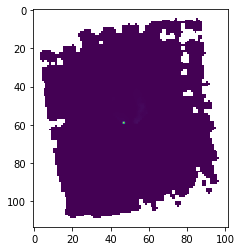

3.9123649137132377


In [4]:

s_map = np.zeros_like(Pol_angle)
seperation = Calc_l(RA_grid[50,50],DEC_grid[50,50],RA_grid,DEC_grid)
delta = 0.5
seperation = seperation*(seperation<1.5*delta)*(0.5*delta<seperation)
plt.imshow(seperation)
plt.show()
Pol_mask = Pol_angle*(seperation>0)
plt.imshow(Pol_mask)
plt.show()
Pol_diff =  ((Pol_angle-Pol_angle[50,50])**2)*(seperation>0)
plt.imshow(Pol_diff)
plt.show()
S = np.sqrt(np.nansum(Pol_diff)/np.count_nonzero(Pol_diff))
print(S)
s_map[50,50] = S


Use this one method over all the sky map with a nested for loop

In [5]:


s_map = np.zeros_like(Pol_angle)
for i in range(RA_grid.shape[0]):
    for j in range(RA_grid.shape[1]):
        seperation = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
        seperation = seperation*(seperation<1.5*0.5)*(0.5*0.5<seperation)
        # plt.imshow(seperation)
        # plt.show()
        Pol_mask = Pol_angle*(seperation>0)
        # plt.imshow(Pol_mask)
        # plt.show()
        Pol_diff =  ((Pol_angle- Pol_angle[i,j])**2)*(seperation>0)
        # plt.imshow(Pol_diff)
        # plt.show()
        S = np.sqrt(np.nansum(Pol_diff)/np.count_nonzero(Pol_diff))
        s_map[i,j] = S


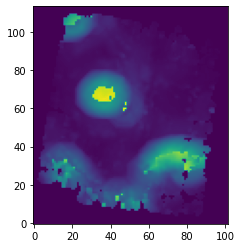

In [6]:
plt.imshow(s_map,origin='lower')
plt.show()